In [28]:
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [2]:
sns.set_style('whitegrid')
sns.set_palette('pastel')

In [3]:
df = pd.read_csv('../../data/processed/sleep_cycle_productivity_cleaned.csv')

In [5]:
# 연속형 -> 순서형 
ordered_score = CategoricalDtype(categories=list(range(1, 11)), ordered=True)

# 적용

df['Productivity Score'] = df['Productivity Score'].astype(ordered_score)
df['Mood Score'] = df['Mood Score'].astype(ordered_score)
df['Stress Level'] = df['Stress Level'].astype(ordered_score)

#gender 범주형 변환 
df['Weekday'] = df['Weekday'].astype('category')
df['Gender'] = df['Gender'].astype('category')


In [6]:
df['Sleep Quality'] = df['Sleep Quality'].apply(lambda x: 0 if x <= 5 else 1)

In [9]:
df.head(5)

,Date,Age,Gender,Sleep Start Time,Sleep End Time,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level,Weekday
0,2024-04-12,30,2,23.33,4.61,5.28,0,86,116,8.808920,8,3,6,Friday
1,2024-11-04,40,0,21.02,2.43,5.41,0,32,88,6.329833,10,3,7,Monday
2,2024-08-31,20,1,22.10,3.45,5.35,1,17,59,8.506306,10,9,10,Saturday
3,2024-02-22,30,2,23.10,6.65,7.55,1,46,80,6.070240,8,4,2,Thursday
4,2024-02-23,40,2,21.42,4.17,6.75,1,61,94,11.374994,8,7,9,Friday


In [21]:

# 타깃과 피처 분리
X = df.drop(columns=['Sleep Quality', 'Date', 'Sleep Start Time', 'Sleep End Time'])
y = df['Sleep Quality']

ordinal_cols = ['Productivity Score', 'Mood Score', 'Stress Level']
nominal_cols = ['Gender', 'Weekday']
continuous_cols = ['Age', 'Total Sleep Hours', 'Exercise (mins/day)', 
                   'Screen Time Before Bed (mins)', 'Work Hours (hrs/day)']

# 전처리
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), continuous_cols + ordinal_cols),
    ('cat', OneHotEncoder(drop='first'), nominal_cols)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', random_state=42))
])

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 학습
clf.fit(X_train, y_train)

# 평가
accuracy = clf.score(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')


Test accuracy: 0.4820


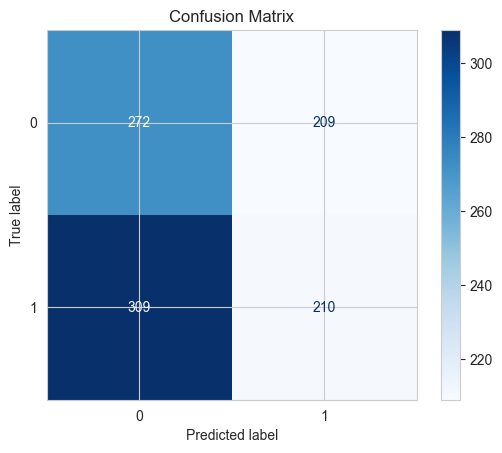

In [26]:

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


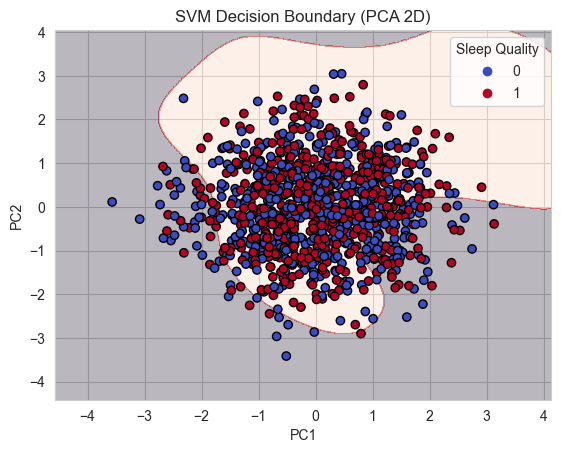

In [29]:

# PCA 2차원 축소 (테스트 데이터만)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(clf.named_steps['preprocessor'].transform(X_test))

# SVM 결정 경계용 모델: 테스트용 데이터 차원 축소해서 별도로 학습
clf_2d = SVC(kernel='rbf', random_state=42)
clf_2d.fit(X_test_pca, y_test)

# 그리드 생성
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, edgecolor='k', cmap='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('SVM Decision Boundary (PCA 2D)')
plt.legend(*scatter.legend_elements(), title="Sleep Quality")
plt.show()
